In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#!cd /content/gdrive/MyDrive
#!git clone https://github.com/augmentedstartups/yolov7.git
#!cd yolov7
#!pip install -r requirements.txt
#!pip install roboflow

Mounted at /content/gdrive


After we mount the dir from google drive we load in the model I trained fror the obstacles.

In [ ]:
!cd /content/gdrive/MyDrive
#!rm -rf yolov7

The training also has resulting parameters of precision and recall. Metrics which have been discussed in the presentations. As shown, these precision and recall metrics for our program yield a .99 - .98 percent accuracy in predictions when tested on our 'Test' image set.

Precision: True positive predictions out of all positive predictions

Recall: Correct True predictions out of all positives that should have been guessed in the model

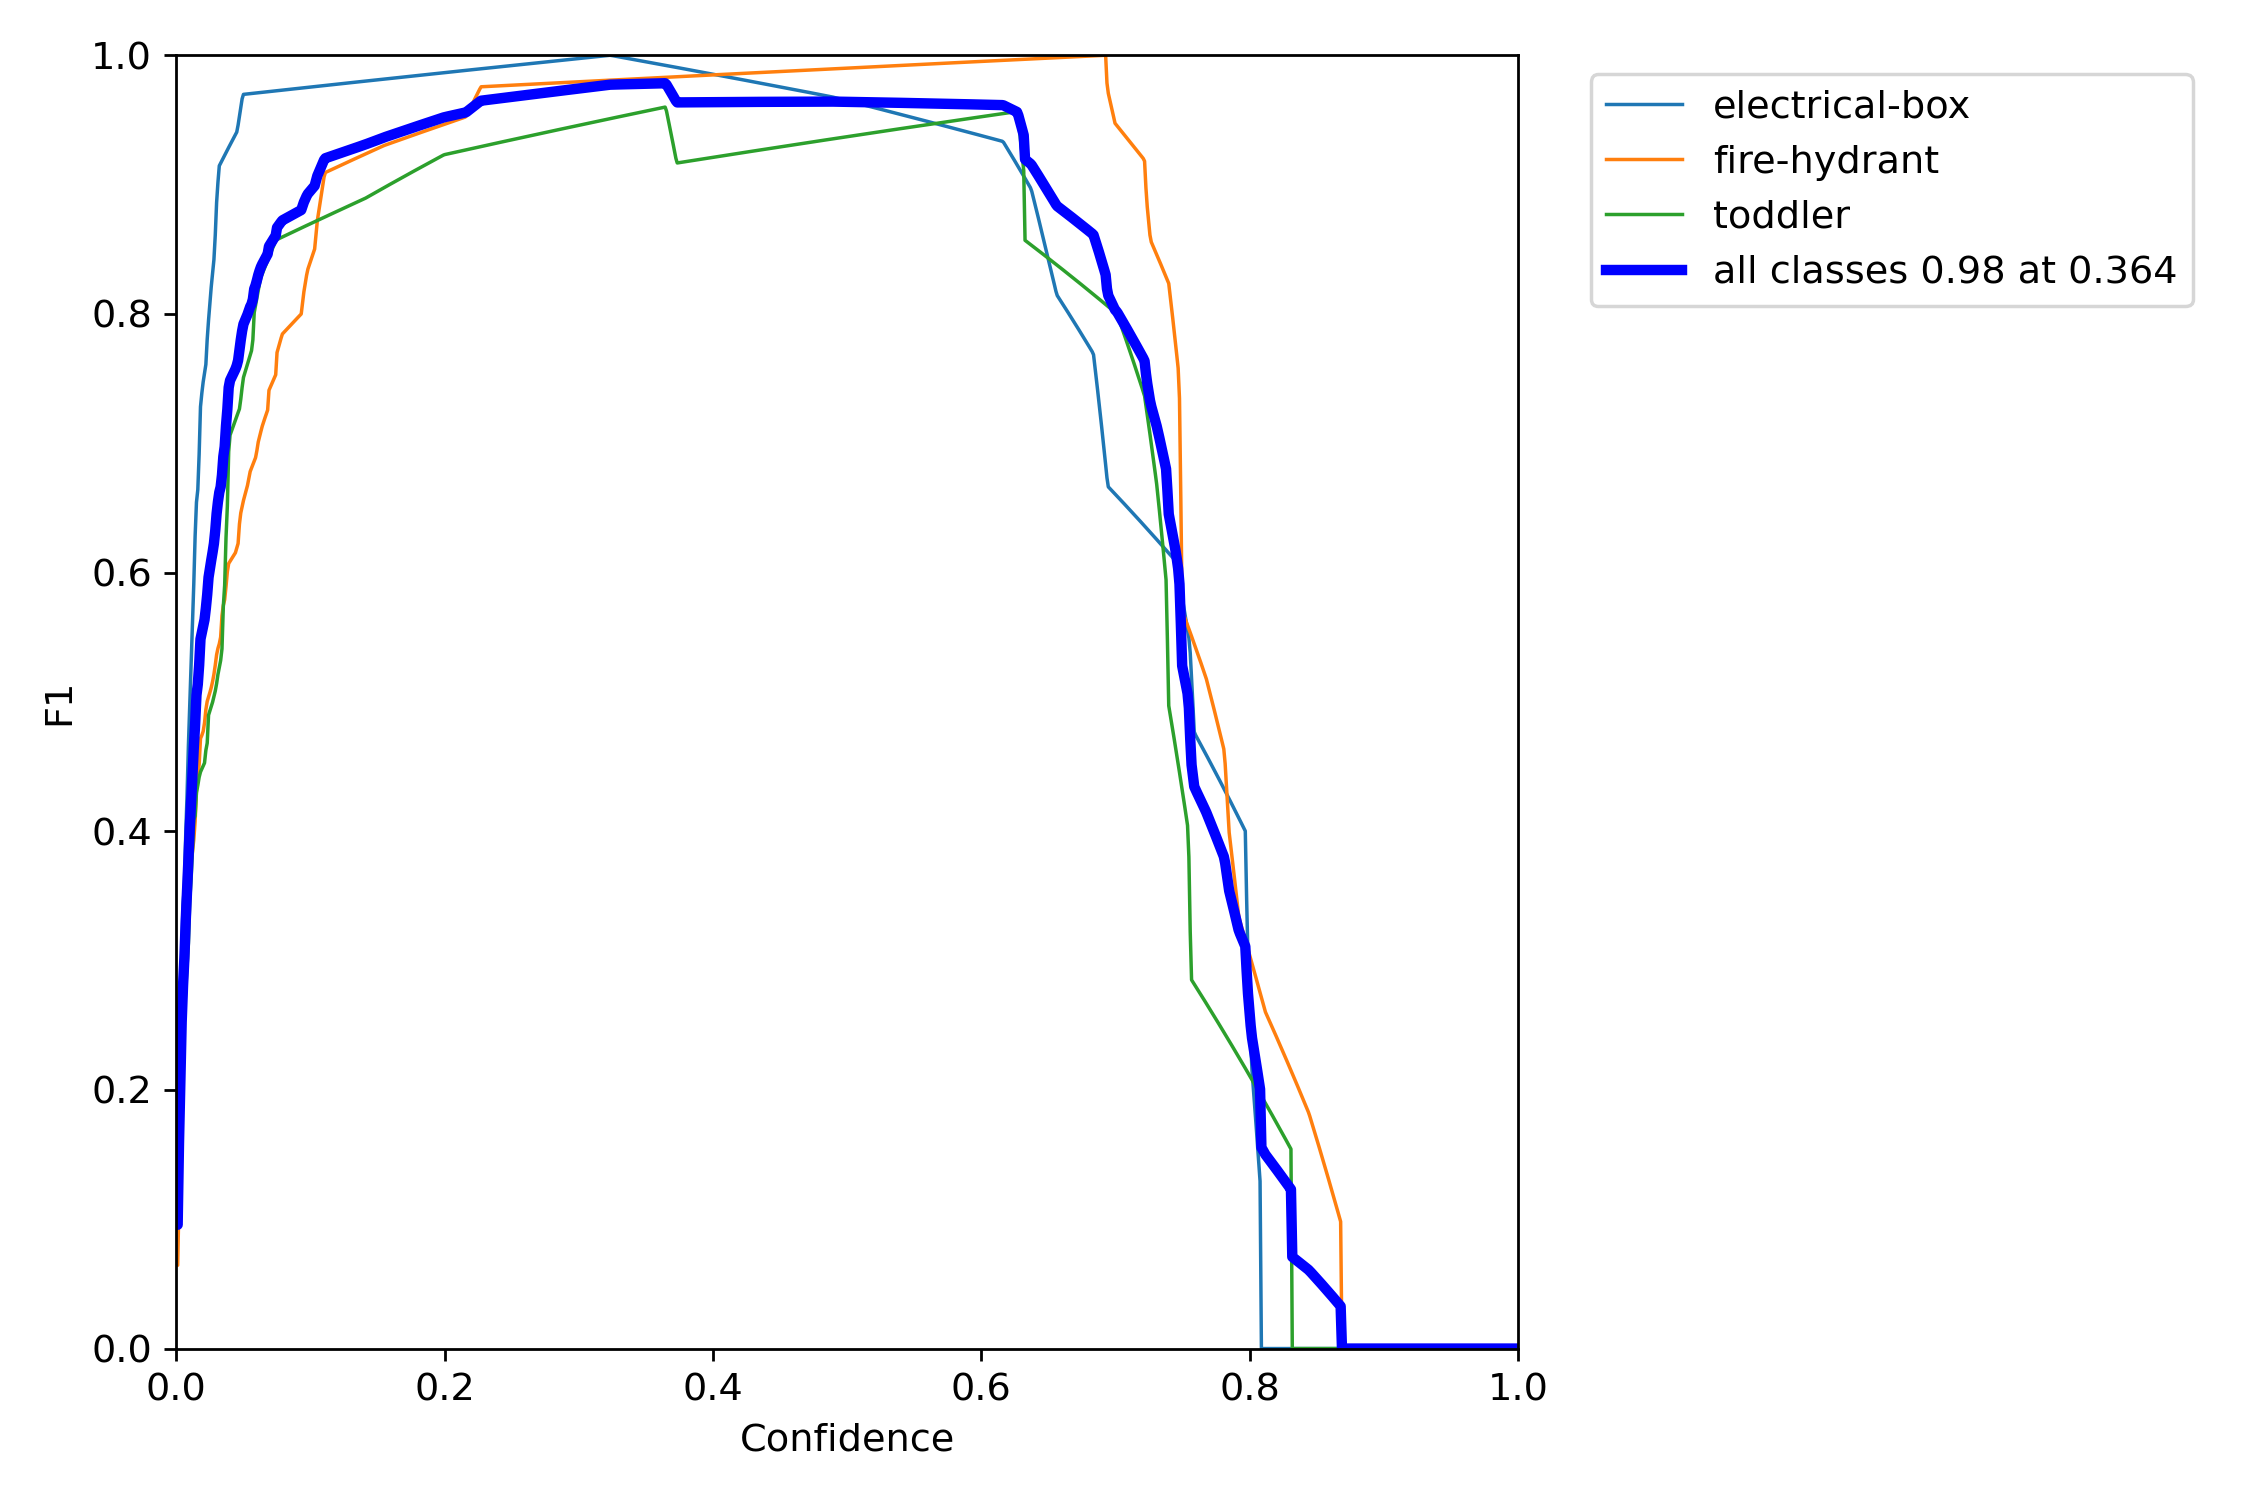

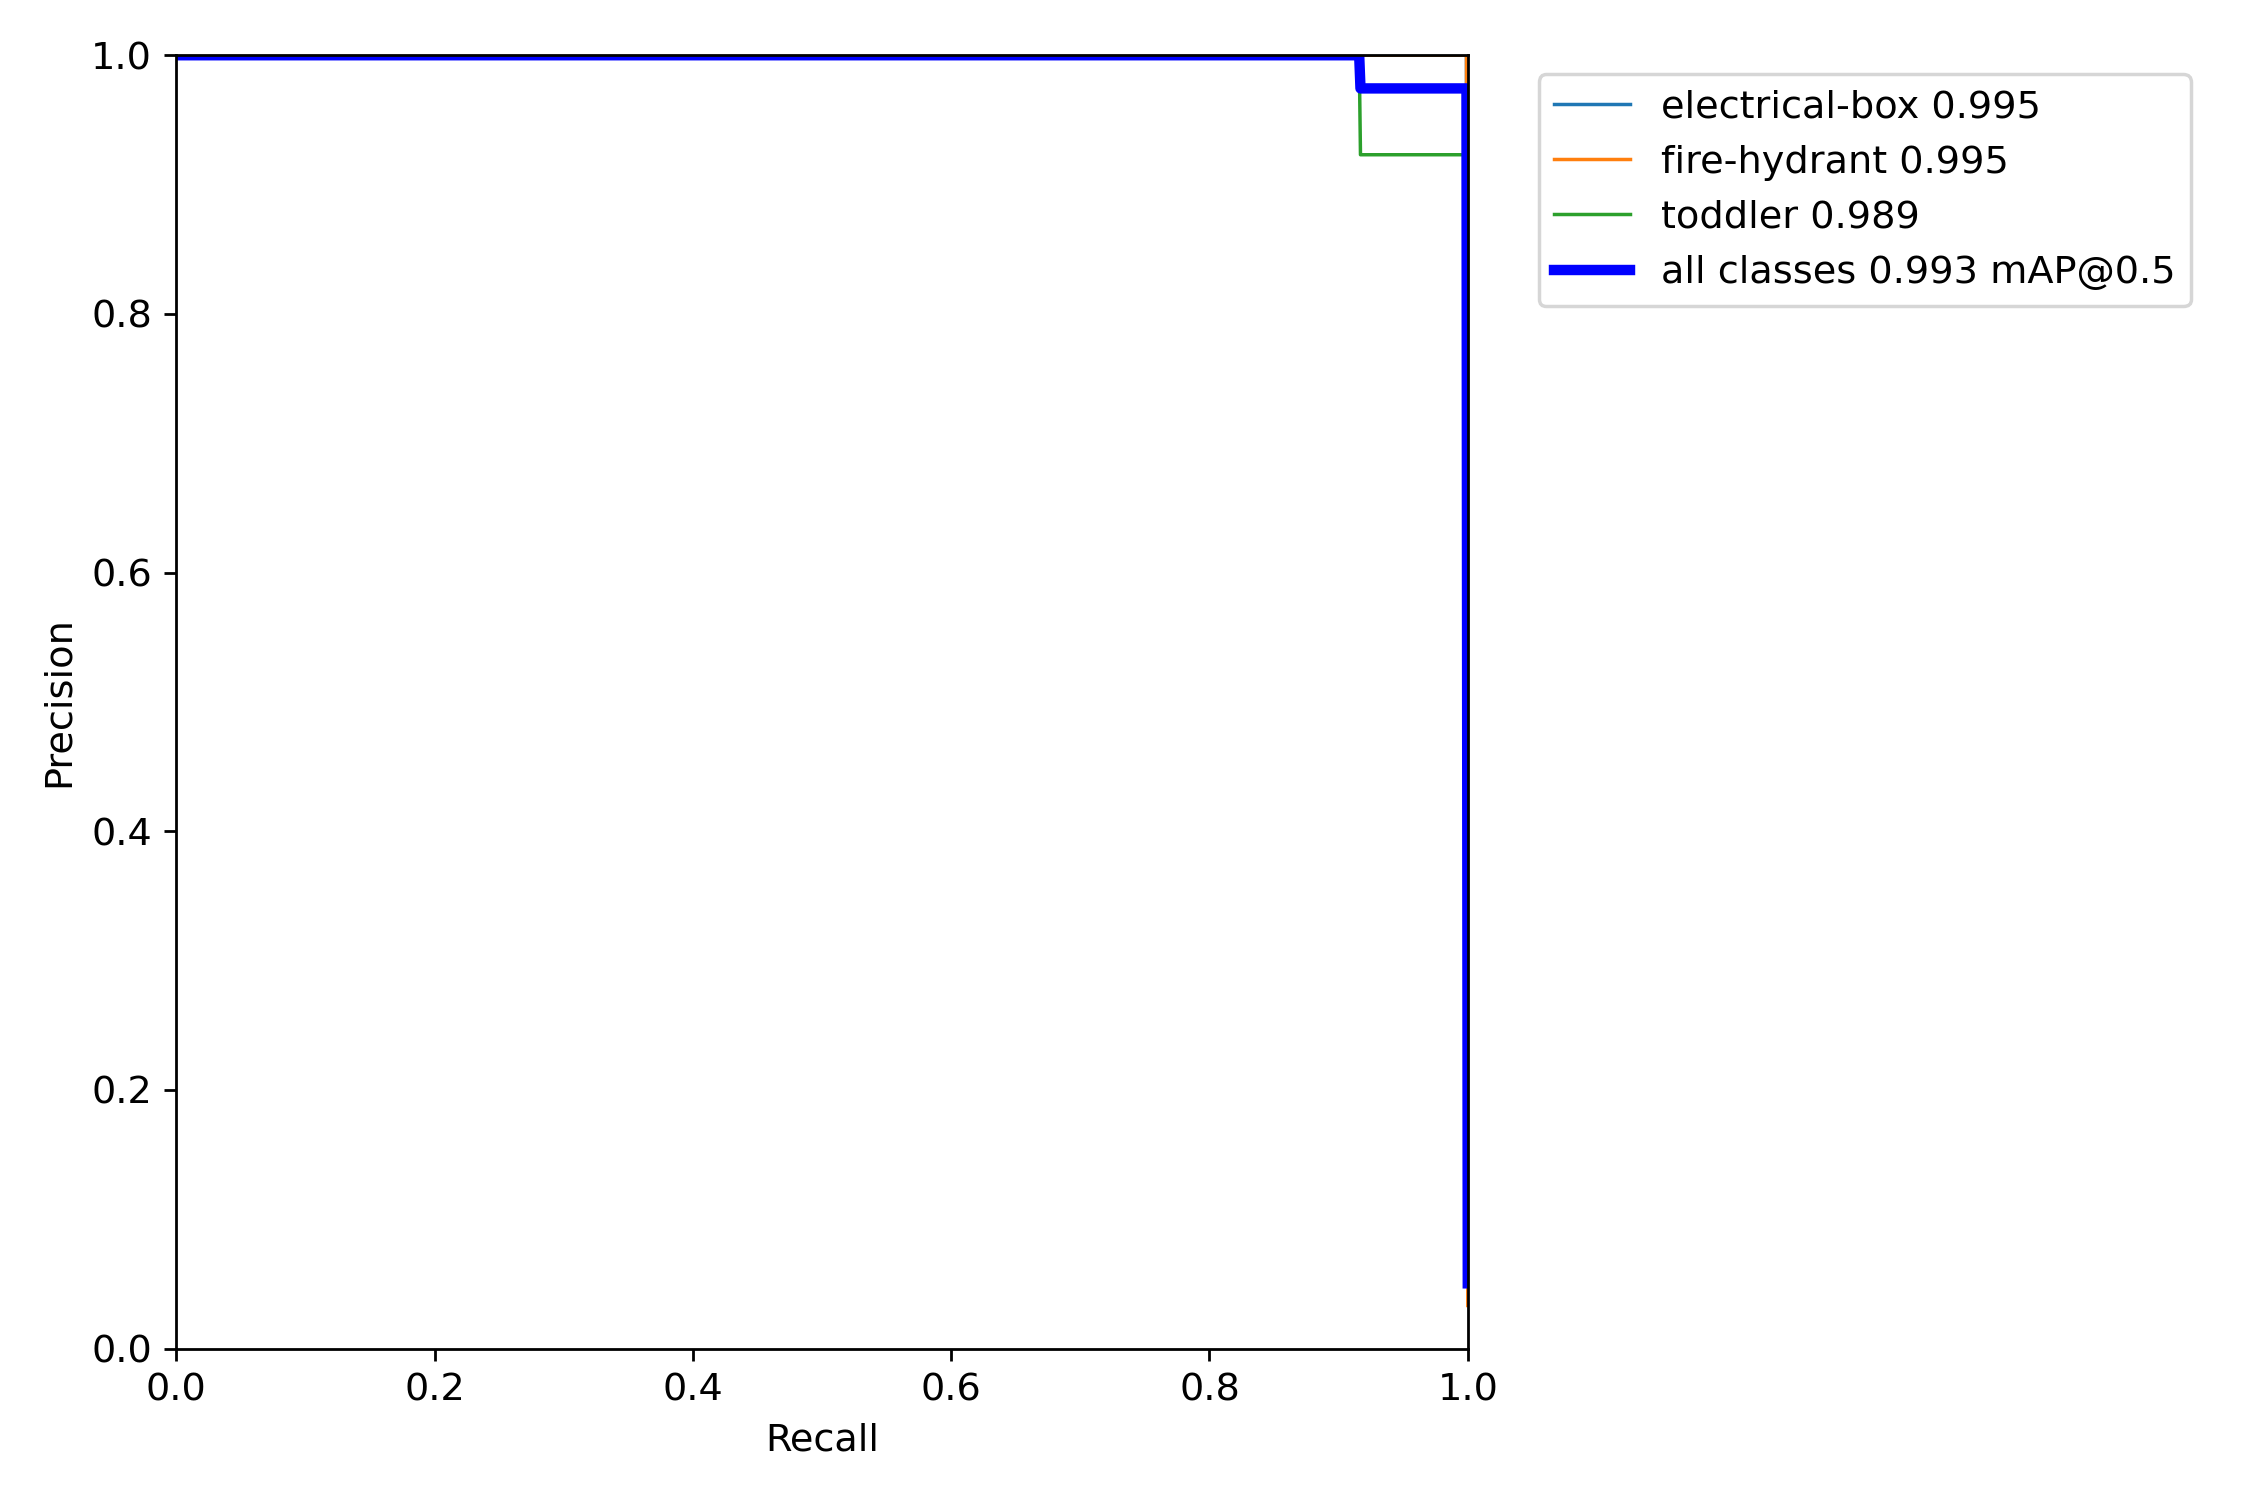

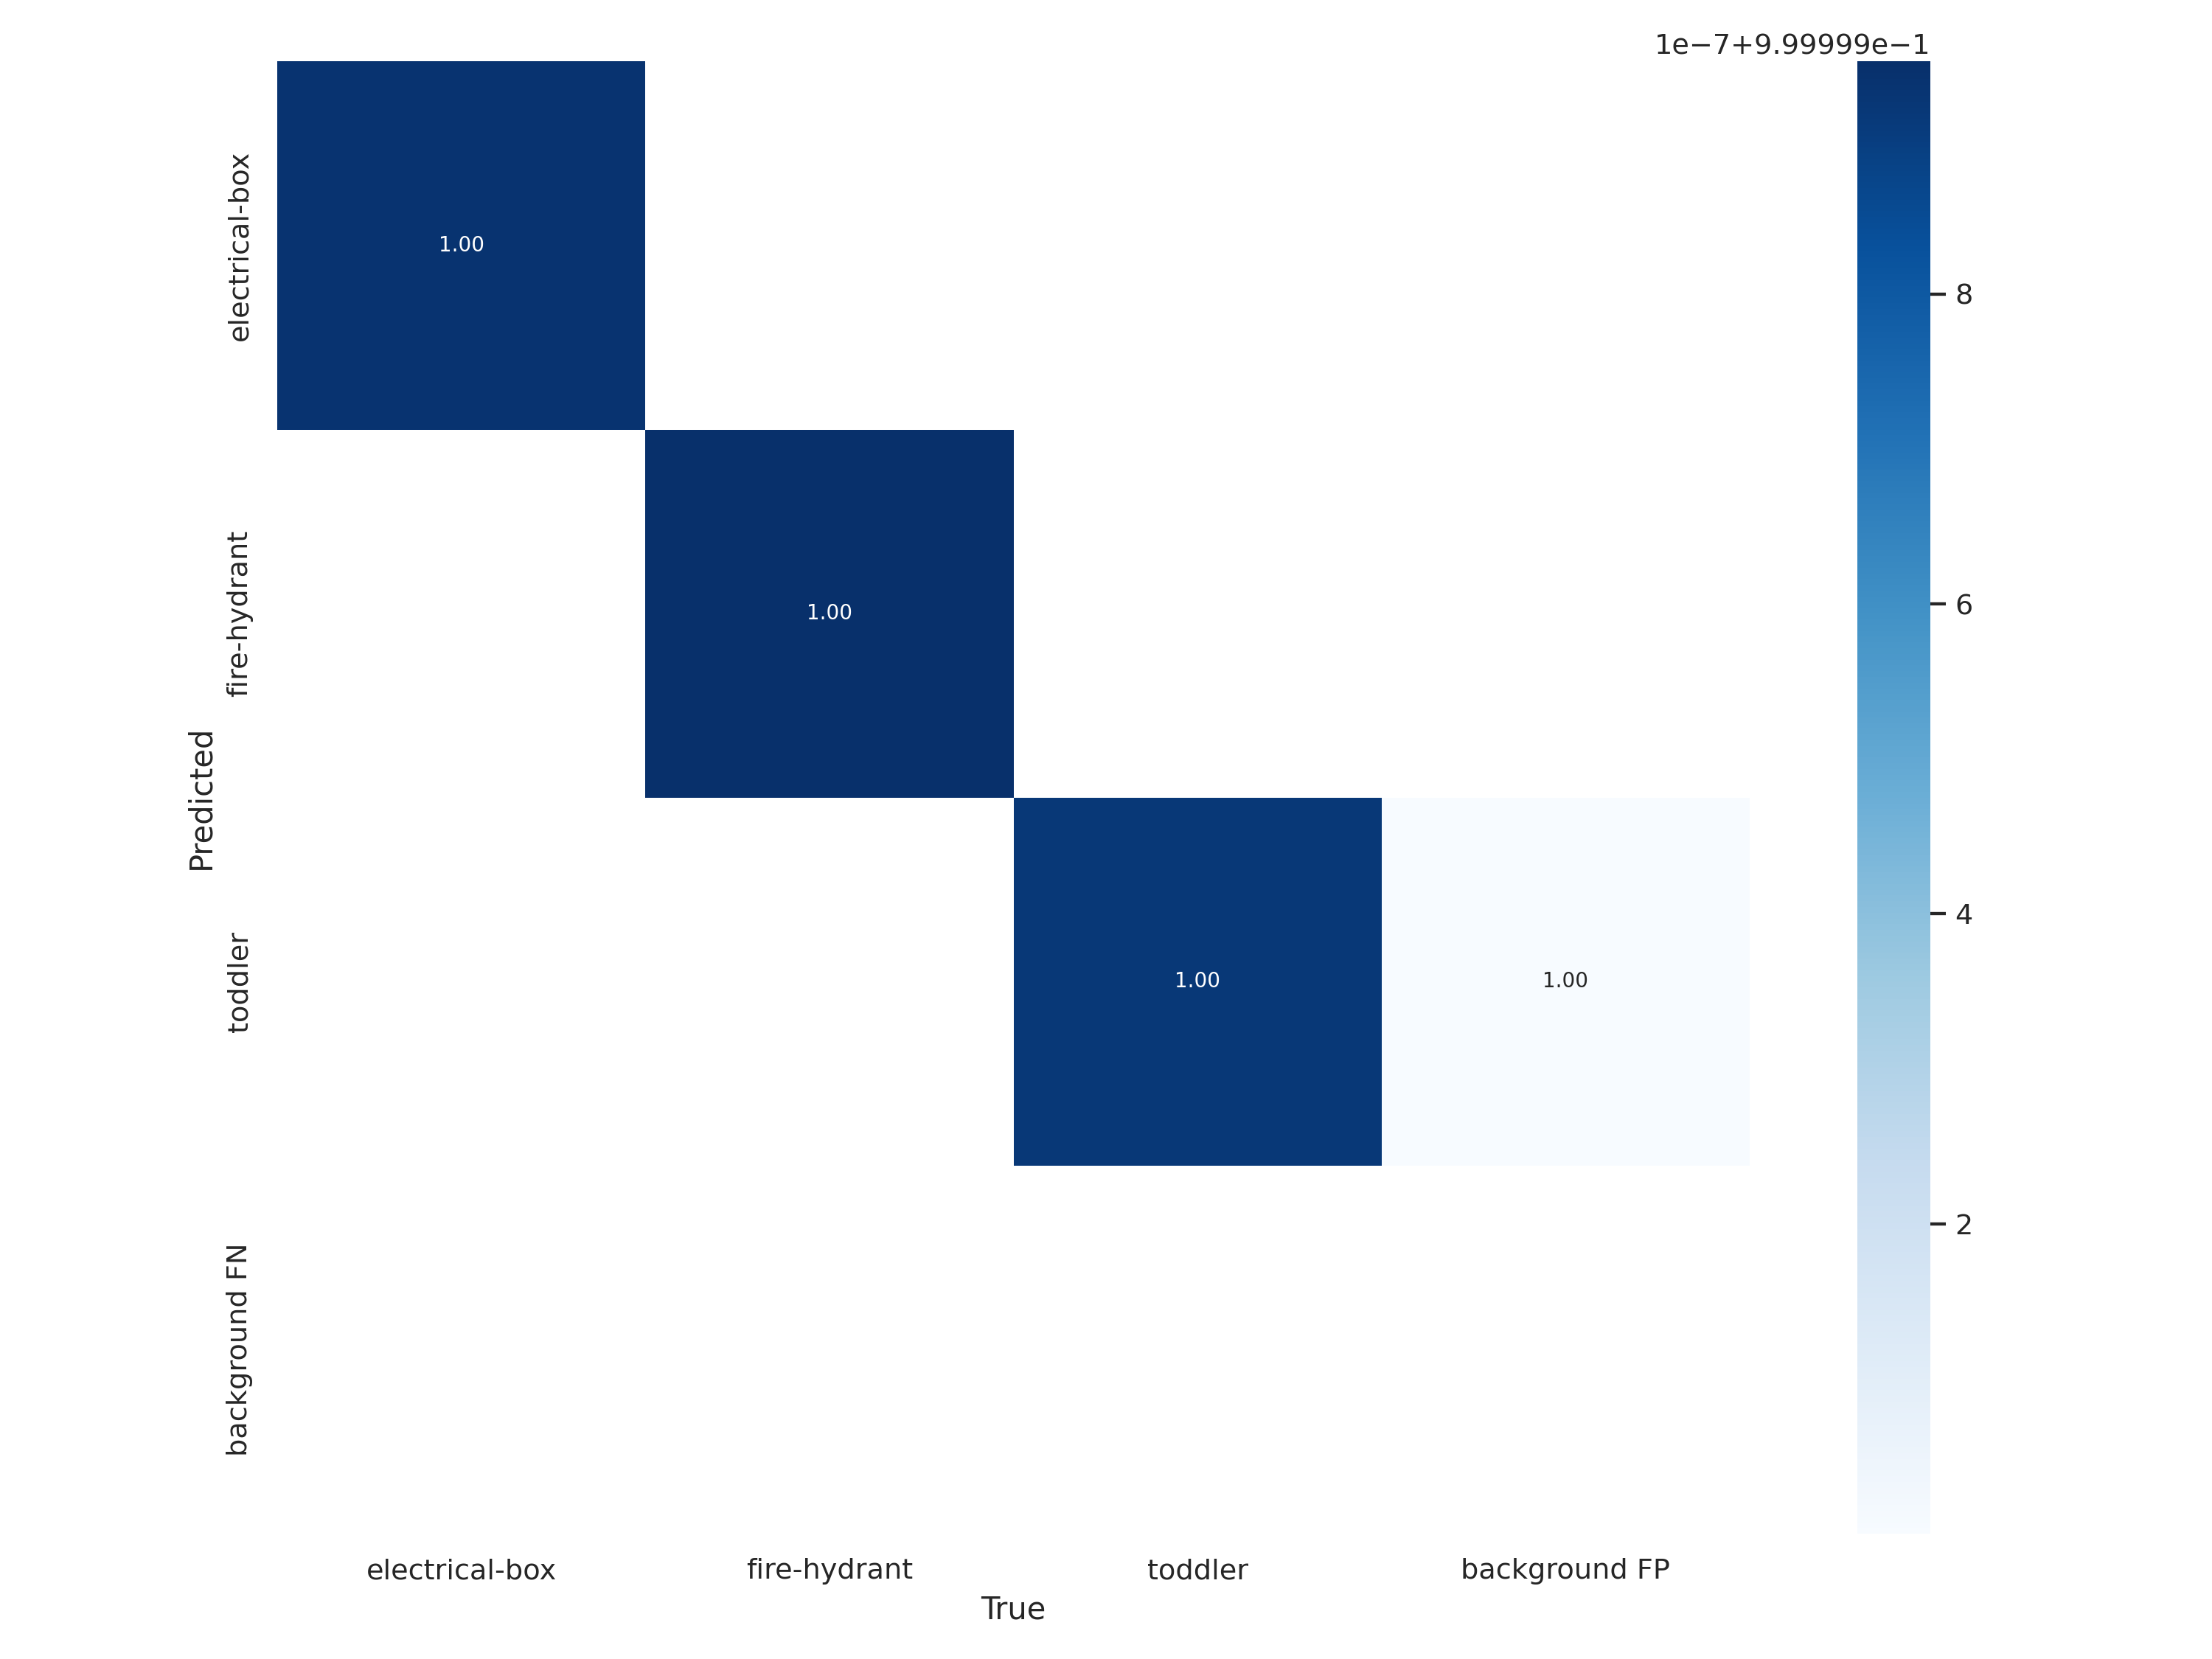

In [ ]:
from IPython.display import Image
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/F1_curve.png", width=400, height=400))
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/PR_curve.png", width=400, height=400))
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp/confusion_matrix.png", width=500, height=500))

Running this section shows the models preictions on the test images

Inferencing:


In [ ]:
import os
import sys
sys.path.append('/content/gdrive/MyDrive/yolov7')


import argparse
import time
from pathlib import Path
import cv2
import torch
import numpy as np
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

In [ ]:
classes_to_filter = None  #if you wanna get rid of any of the classes


opt  = {

    "weights": "/content/gdrive/MyDrive/yolov7/runs/train/exp/weights/best.pt", # If this doesn't work change to 054th epoch pls
    "yaml"   : "Automow-1/data.yaml",
    "img-size": 640,
    "conf-thres": 0.25,
    "iou-thres" : 0.45,
    "device" : '0',
    "classes" : classes_to_filter

}

Video Inferencing. Put in a video into the g-drive before it is mounted to google colab. Then the path can be specified to access it. This is if we are passing a vid in through the algorithm

**ALWAYS RUN**

In [ ]:
##ALWAYS RUN - Helper function that allows video-inferencing for YoloV7
video = cv2.VideoCapture(video_path)

fps = video.get(cv2.CAP_PROP_FPS)
w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'DIVX'),fps , (w,h))
torch.cuda.empty_cache()
with torch.no_grad():
  weights, imgsz = opt['weights'], opt['image-size']
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)
  stride = int(model.stride.max())
  imgsz = check_img_size(imgsz, s=stride)
  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))

  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(opt['classes'].index(class_name))

  for j in range(nframes):

      ret, img0 = video.read()
      if ret:
        img = letterbox(img0, imgsz, stride=stride)[0]
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
          img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment= False)[0]


        pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
        t2 = time_synchronized()
        for i, det in enumerate(pred):
          s = ''
          s += '%gx%g ' % img.shape[2:]  # print string
          gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
          if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

            for c in det[:, -1].unique():
              n = (det[:, -1] == c).sum()  # detections per class
              s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

            for *xyxy, conf, cls in reversed(det):

              label = f'{names[int(cls)]} {conf:.2f}'
              plot_one_box(xyxy, img0, label=label, color=colors[int(cls)], line_thickness=3)

        print(f"{j+1}/{nframes} frames processed")
        output.write(img0)
      else:
        break


output.release()
video.release()

CalledProcessError: ignored

Run if we are passing a video in

Trying webcam

In [ ]:
!sudo apt-get install v4l-utils
!v4l2-ctl --list-devices

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libv4l-0 libv4l2rds0 libv4lconvert0
The following NEW packages will be installed:
  libv4l-0 libv4l2rds0 libv4lconvert0 v4l-utils
0 upgraded, 4 newly installed, 0 to remove and 11 not upgraded.
Need to get 823 kB of archives.
After this operation, 2,847 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libv4lconvert0 amd64 1.22.1-2build1 [82.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libv4l-0 amd64 1.22.1-2build1 [44.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libv4l2rds0 amd64 1.22.1-2build1 [17.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 v4l-utils amd64 1.22.1-2build1 [678 kB]
Fetched 823 kB in 2s (350 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based fr

As you see the list of devices that are currently connected are showing up.
Btw, change the IP address if u need to
(try with hotspot, make sure both connected to same internet)

First one should be IP of the jetson
2nd one should be IP of your PC (**CALL IF THIS IS** **CONFUSING**)

In [ ]:
!video-viewer --bitrate 1000000 /dev/video0 rtp://10.192.26.85:1234

/bin/bash: line 1: video-viewer: command not found


**Now ssh into the JETSON from ur PC and run the next command on ur PC with the IP address of your PC**

In [ ]:
#ssh into the jetson from PC
!video-viewer /dev/video0 rtp://<replace with PC IP>:1234

/bin/bash: line 1: replace: No such file or directory


In [ ]:
#open up a new tab on your terminal in ur PC and pass this comment
!gst-launch-1.0 -v udpsrc port=1234 \
 caps = "application/x-rtp, media=(string)video, clock-rate=(int)90000, encoding-name=(string)H264, payload=(int)96" ! \
 rtph264depay ! decodebin ! videoconvert ! autovideosink

/bin/bash: line 1: gst-launch-1.0: command not found


This should open up another window with the video streaming on ur PC

This should run a script without failures

In [ ]:
#running the detection script on a RTP strem - see if it works
!python detect.py --weights runs/train/yolov7/weights/best.pt --conf 0.1 --source rtp://<replace with PC IP>:1234

/bin/bash: line 1: replace: No such file or directory


In [ ]:
#Should run on webcam instead
!cd /content/gdrive/MyDrive
!cd yolov7
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source 0

/bin/bash: line 1: cd: yolov7: No such file or directory
Namespace(weights=['runs/train/exp/weights/best.pt'], source='0', img_size=640, conf_thres=0.1, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.1.0+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
Model Summary: 314 layers, 36492560 parameters, 6194944 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

qt.qpa.xcb: could not connect to display 
qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/usr/local/lib/python3.10/dist-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the a

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL
import io
import html
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0

with torch.no_grad():
  weights, imgsz = opt['weights'], (480,640)
  set_logging()
  device = select_device(opt['device'])
  half = device.type != 'cpu'
  model = attempt_load(weights, map_location=device)  # load FP32 model
  stride = int(model.stride.max())  # model stride

  if half:
    model.half()

  names = model.module.names if hasattr(model, 'module') else model.names
  colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
  if device.type != 'cpu':
    model(torch.zeros(1, 3, imgsz[0], imgsz[1]).to(device).type_as(next(model.parameters())))
  classes = None
  if opt['classes']:
    classes = []
    for class_name in opt['classes']:
      classes.append(opt['classes'].index(class_name))

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img0 = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    img = letterbox(img0, imgsz, stride=stride)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()
    img /= 255.0  =
    if img.ndimension() == 3:
      img = img.unsqueeze(0)

    # Inference
    t1 = time_synchronized()
    pred = model(img, augment= False)[0]


    pred = non_max_suppression(pred, opt['conf-thres'], opt['iou-thres'], classes= classes, agnostic= False)
    t2 = time_synchronized()
    for i, det in enumerate(pred):
      s = ''
      s += '%gx%g ' % img.shape[2:]  # print string
      gn = torch.tensor(img0.shape)[[1, 0, 1, 0]]
      if len(det):
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0.shape).round()

        for c in det[:, -1].unique():
          n = (det[:, -1] == c).sum()  # detections per class
          s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "

        for *xyxy, conf, cls in reversed(det):

          label = f'{names[int(cls)]} {conf:.2f}'
          plot_one_box(xyxy, bbox_array, label=label, color=colors[int(cls)], line_thickness=3)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)

    bbox = bbox_bytes


<IPython.core.display.Javascript object>

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
